# 时间序列分析nginx日志


本次只分析访问量


# 数据采集


首先，加载nginx的access数据


## 压缩包

In [1]:
from zipfile import ZipFile

z = ZipFile('./access.zip')
z.namelist()

['access.log']

## 读文件

nginx的日志设置为


```
log_format  main  '$remote_addr - $remote_user [$time_local] "$request" '
                      '$status $body_bytes_sent "$http_referer" '
                      '"$http_user_agent" "$http_x_forwarded_for"';
```

In [2]:
import pandas as pd
from zipfile import ZipFile

names = ['remote_addr', '-', 'remote_user', 'time_local', 'time_zone', 'request', 'status', 'body_bytes_sent', 'http_referer', 'http_user_agent', 'http_x_forwarded_for' ] # 设置表头

z = ZipFile('./access.zip') # 加载压缩包
f = z.open(z.namelist()[0], 'r') # 读取压缩包中第一个文件
df = pd.read_table(f, sep=' ', header=None, names=names, encoding='unicode_escape') # 按照表头读取压缩包内文件
z.close() # 关闭压缩包
df = df.drop(columns=['-']) # 去掉多余的列
df

,remote_addr,remote_user,time_local,time_zone,request,status,body_bytes_sent,http_referer,http_user_agent,http_x_forwarded_for
0,60.165.14.57,-,[17/Jun/2013:14:50:18,+0800],GET /forum.php?mod=forumdisplay&fid=2 HTTP/1.1,200,12941,http://www.moli2.com/forum.php,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,-
1,60.165.14.57,-,[17/Jun/2013:14:50:18,+0800],GET /uc_server/avatar.php?uid=1&size=small HTT...,301,5,http://www.moli2.com/forum.php?mod=forumdispla...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,-
2,60.165.14.57,-,[17/Jun/2013:14:50:18,+0800],GET /home.php?mod=misc&ac=sendmail&rand=137145...,200,5,http://www.moli2.com/forum.php?mod=forumdispla...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,-
3,60.165.14.57,-,[17/Jun/2013:14:50:20,+0800],GET /forum.php?mod=viewthread&tid=3&extra=page...,200,21295,http://www.moli2.com/forum.php?mod=forumdispla...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,-
4,60.165.14.57,-,[17/Jun/2013:14:50:20,+0800],GET /uc_server/avatar.php?uid=1&size=middle HT...,301,5,http://www.moli2.com/forum.php?mod=viewthread&...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,-
...,...,...,...,...,...,...,...,...,...,...
889069,5.10.83.68,-,[24/Sep/2013:09:33:32,+0800],GET /forum.php?mod=viewthread&tid=286&extra= H...,200,24332,-,Mozilla/5.0 (compatible; AhrefsBot/5.0; +http:...,-
889070,180.153.160.116,-,[24/Sep/2013:09:34:04,+0800],POST /api/manyou/my.php HTTP/1.0,200,152,http://www.moli2.com/api/manyou/my.php,Mozilla/5.0 (Windows; U; Windows NT 5.1; zh-CN...,-
889071,183.60.215.40,-,[24/Sep/2013:09:35:31,+0800],GET /forum.php?mod=forumdisplay&fid=68&filter=...,200,29451,-,Mozilla/5.0 (compatible; EasouSpider; +http://...,-
889072,58.246.163.172,-,[24/Sep/2013:09:51:38,+0800],POST /api/manyou/my.php HTTP/1.0,200,152,http://www.moli2.com/api/manyou/my.php,Mozilla/5.0 (Windows; U; Windows NT 5.1; zh-CN...,-


nginx 默认的时间有不能呗datetime识别，需要修改


- 原始值: \[18/Mar/2018:20:05:08 +0800\]


- 修改值: 18/Mar/2018 20:05:08 +0800


使用正则表达式处理

In [3]:
import re

pattern = re.compile(r'^\[(\w+\/\w+/\w+):(\w+:\w+:\w+)\s(\+\w+)\]$')

def to_datetime(s):
    """
    改成时间格式
    """
    res = pattern.match(s)
    return pd.to_datetime(res.group(1) + ' ' + res.group(2) + res.group(3))

df['date'] = df['time_local'] + ' ' + df['time_zone'] # 组合datetime和zone作为date
df['date'] = df['date'].apply(to_datetime) # 应用正则表达式改成to_datetime可识别的常规时间格式
df['date']

0        2013-06-17 14:50:18+08:00
1        2013-06-17 14:50:18+08:00
2        2013-06-17 14:50:18+08:00
3        2013-06-17 14:50:20+08:00
4        2013-06-17 14:50:20+08:00
                    ...           
889069   2013-09-24 09:33:32+08:00
889070   2013-09-24 09:34:04+08:00
889071   2013-09-24 09:35:31+08:00
889072   2013-09-24 09:51:38+08:00
889073   2013-09-24 09:54:10+08:00
Name: date, Length: 889074, dtype: datetime64[ns, pytz.FixedOffset(480)]

按照时间合并

In [4]:
combination = pd.Grouper(key='date', freq='1H') # 混合器，按照date列的1小时合并
count = df.groupby(combination).agg({'request': 'count'}) # 合并之后记录count(总量)
count

,request
date,
2013-06-17 14:00:00+08:00,94
2013-06-17 15:00:00+08:00,176
2013-06-17 16:00:00+08:00,352
2013-06-17 17:00:00+08:00,12
2013-06-17 18:00:00+08:00,15
...,...
2013-09-24 05:00:00+08:00,107
2013-09-24 06:00:00+08:00,179
2013-09-24 07:00:00+08:00,84


<AxesSubplot:xlabel='date'>

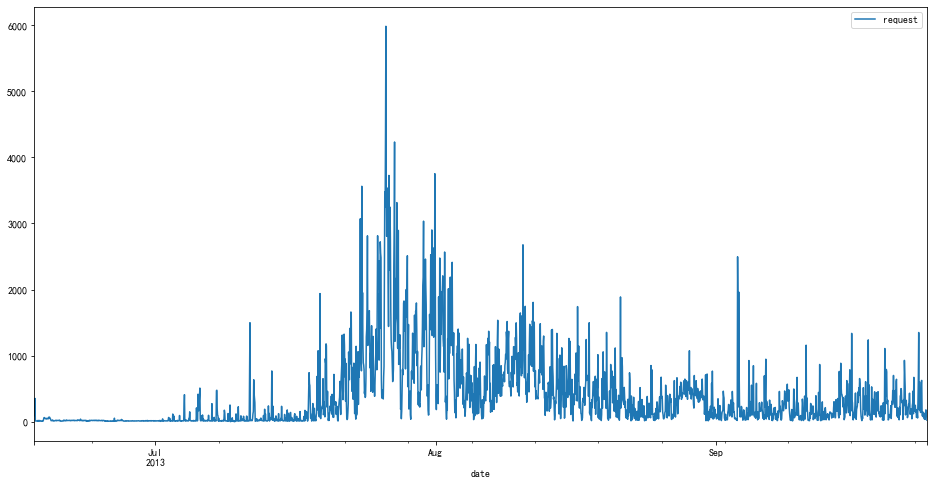

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = ['SimHei'] # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False

count.plot(figsize=(16,8))

# 自相关性

array([1.        , 0.76672756, 0.72044523, 0.67531535, 0.6346603 ,
       0.58229549, 0.54865013, 0.50382754, 0.48749399, 0.4564054 ,
       0.46424087, 0.47023305, 0.47082976, 0.46673327, 0.46612993,
       0.4670657 , 0.46358716, 0.49170909, 0.51692118, 0.54913731,
       0.5761074 , 0.61089302, 0.63298577, 0.65881329, 0.67440808,
       0.66077398, 0.62820574, 0.58652855, 0.54236803, 0.50710714,
       0.50776864, 0.45336868, 0.42477026, 0.40999213, 0.40315026,
       0.39377671, 0.40377969, 0.39313005, 0.39112107, 0.37217127,
       0.38899283, 0.40647172, 0.45650111, 0.48237307, 0.51293452,
       0.5421473 , 0.5791775 , 0.58860513, 0.59927318, 0.61240046,
       0.56827149, 0.53776727, 0.48934314, 0.45190606, 0.42668016,
       0.39749584, 0.37188158, 0.36696488, 0.35585428, 0.36019857,
       0.36459633, 0.3542487 , 0.35375516, 0.35381412, 0.37292756,
       0.37158812, 0.4018806 , 0.4402729 , 0.45888254, 0.48412661,
       0.50693034, 0.52126901, 0.53428532, 0.52209599, 0.49088

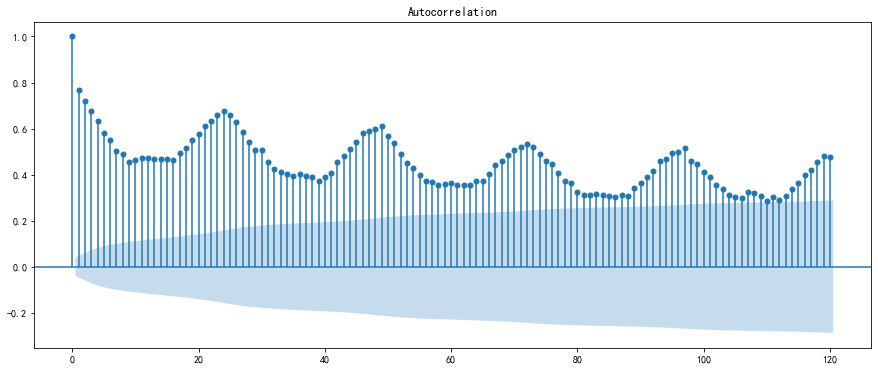

In [6]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
fig, ax = plt.subplots(figsize=(15, 6))
tsaplots.plot_acf(count, lags=120, ax=ax) # 自相关性画图120阶
stattools.acf(count, nlags=120)

# 偏自相关

array([ 1.00000000e+00,  7.67050939e-01,  3.22340773e-01,  1.46710160e-01,
        7.27700656e-02, -3.26364776e-03,  2.12032023e-02, -1.52407203e-02,
        5.05278952e-02,  1.11354121e-02,  1.00509608e-01,  9.83968218e-02,
        5.92853799e-02,  3.04691146e-02,  2.15104746e-02,  3.29815584e-02,
        1.87550519e-02,  1.18464277e-01,  1.22602667e-01,  1.41047580e-01,
        1.22292664e-01,  1.30672391e-01,  9.91289145e-02,  1.07067357e-01,
        1.05587049e-01,  2.41256273e-02, -2.59886933e-02, -6.15489836e-02,
       -6.79905492e-02, -4.50348166e-02,  7.98547526e-02, -7.43766193e-02,
       -6.22620829e-02, -2.86072440e-02, -2.20948959e-02, -3.32599464e-02,
        7.46788804e-03, -3.28458398e-02, -4.07139915e-02, -7.82428332e-02,
       -1.20176544e-02, -2.42358241e-04,  1.01157197e-01,  5.77371538e-02,
        3.73704777e-02,  4.62803196e-02,  8.86930880e-02,  2.37830525e-02,
        2.97944570e-02,  1.01796929e-01, -3.91267127e-02, -8.55946415e-03,
       -5.10490701e-02, -

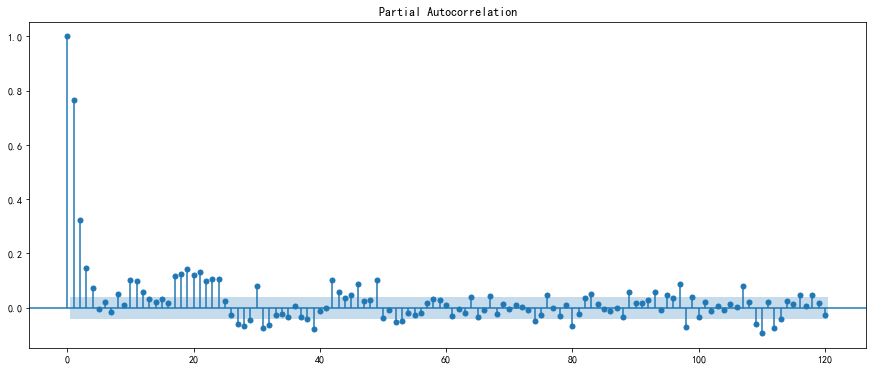

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
tsaplots.plot_pacf(count, lags=120, ax=ax) # 偏自相关性画图120阶
stattools.pacf(count, nlags=120)

# 单位根检验（Dickey-Fuller test）


In [8]:
stattools.adfuller(count)

(-2.3082325205728202,
 0.1693265656570936,
 27,
 2344,
 {'1%': -3.4331428650682807,
  '5%': -2.8627738368607076,
  '10%': -2.567426825246945},
 33608.80020143669)

In [9]:
def dickey(df):
    t = stattools.adfuller(df)
    output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
    output['value']['Test Statistic Value'] = t[0]
    output['value']['p-value'] = t[1]
    output['value']['Lags Used'] = t[2]
    output['value']['Number of Observations Used'] = t[3]
    output['value']['Critical Value(1%)'] = t[4]['1%']
    output['value']['Critical Value(5%)'] = t[4]['5%']
    output['value']['Critical Value(10%)'] = t[4]['10%']
    return output

In [10]:
dickey(count)

,value
Test Statistic Value,-2.308233
p-value,0.169327
Lags Used,27
Number of Observations Used,2344
Critical Value(1%),-3.433143
Critical Value(5%),-2.862774
Critical Value(10%),-2.567427


并不平稳需要做差分


## 一阶差分

,value
Test Statistic Value,-13.53278
p-value,0.0
Lags Used,27
Number of Observations Used,2343
Critical Value(1%),-3.433144
Critical Value(5%),-2.862774
Critical Value(10%),-2.567427


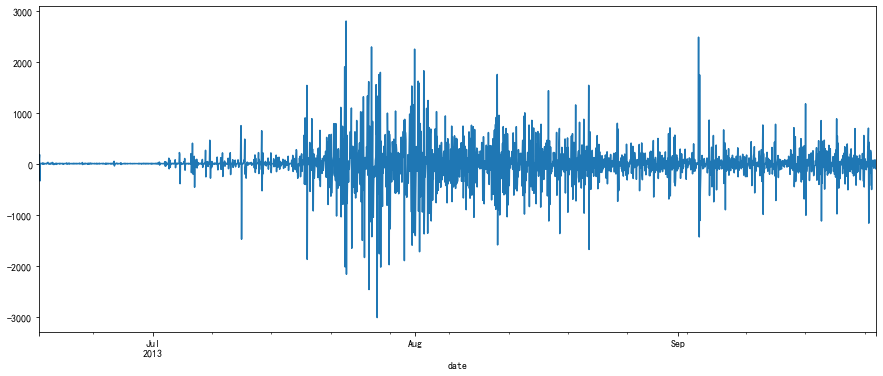

In [11]:
diff = count['request'].diff().dropna()
diff.plot(figsize=(15, 6))
dickey(diff)

# 获取最佳order


AIC:赤池信息准则（AkaikeInformation Criterion，AIC）


BIC:贝叶斯信息准则（Bayesian Information Criterion，BIC）


k为模型参数个数，n为样本数量，L为似然函数



In [12]:
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
orders = arma_order_select_ic(diff, ic=['aic', 'bic'], trend='nc', max_ar=8, max_ma=6)
orders

{'aic':               0             1             2             3             4  \
 0           NaN  34339.852540  34339.332561  34326.251216  34267.587054   
 1  34471.497157  34292.038633  34194.921874  34190.208303  34184.897426   
 2  34382.306207  34198.805668  34191.799942  34193.846756  34034.208443   
 3  34355.514180  34189.816970  34191.775752  34153.625343  34063.698294   
 4  34355.285300  34191.689907  34130.022078  34010.524460  34148.586113   
 5  34350.489545  34182.253427  34093.638135  34011.059832  34013.186882   
 6  34351.883514  34177.910783  34088.590110  34096.230781  34014.635580   
 7  34338.894303  34156.787229  34078.755813  34080.944962  34009.705165   
 8  34337.542377  34154.362615  34079.946025  34081.158616  34012.531377   
 
               5             6  
 0  34217.338529  34201.261017  
 1  34175.662121  34173.588437  
 2  34178.722506  34151.234518  
 3  34154.829749  34153.546361  
 4  34146.384983  34148.367040  
 5  34142.965866  34003.307953  


得到了最佳值


- aic: p=5, q=6


- bic: p=4, q=3


我们可以画个热力图直观表现一下

In [13]:
import seaborn as sns #热力图
def thermodynamicOrder(df, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(df, ax=ax, annot=True, fmt='.2f')
    ax.set_title(title)
    ax.set_xlabel('MA')
    ax.set_ylabel('AR')
    plt.show()

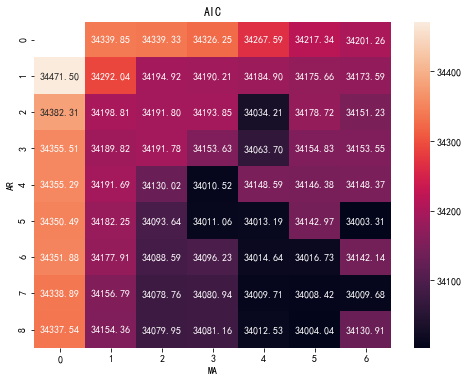

In [14]:
thermodynamicOrder(orders['aic'], 'AIC')

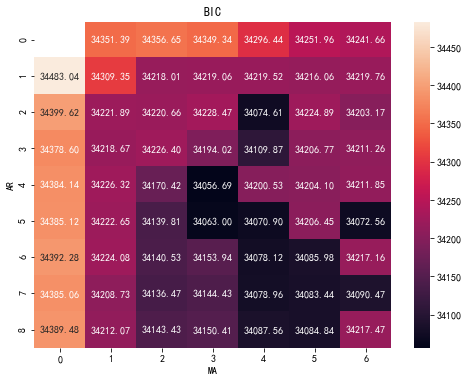

In [15]:
thermodynamicOrder(orders['bic'], 'BIC')

# 模型预测


## 还原差分函数

In [16]:
def revert(diffValues, *lastValue):
    for i in range(len(lastValue)):
        result = []
        lv = lastValue[i]
        for dv in diffValues:
            lv = dv + lv
            result.append(lv)
        diffValues = result
    return diffValues

## 创建模型

In [17]:
from statsmodels.tsa import arima_model

arima516 = arima_model.ARIMA(count, (5, 1, 6)).fit()
arima413 = arima_model.ARIMA(count, (4, 1, 3)).fit()

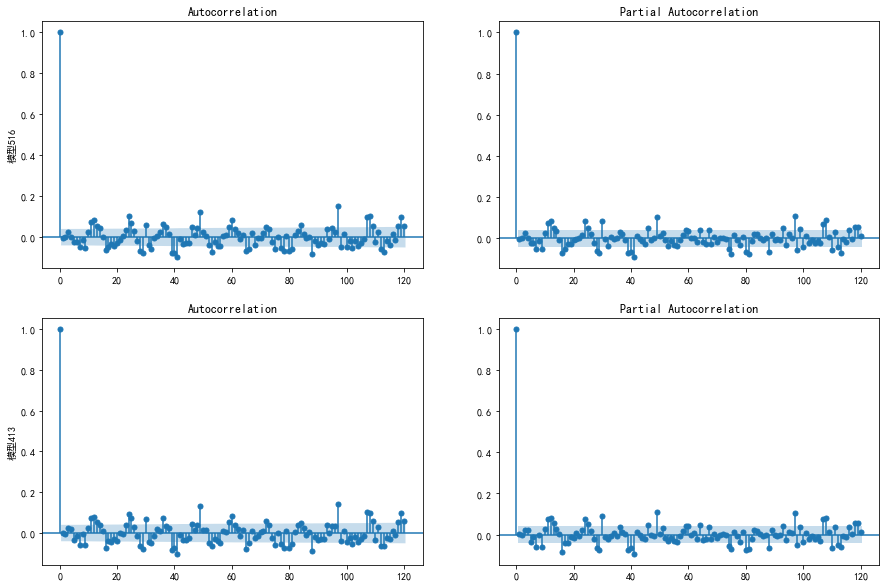

<Figure size 864x576 with 0 Axes>

In [18]:
resid = arima516.resid
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0, 0].set_ylabel('模型516')
fig = tsaplots.plot_acf(resid.values.squeeze(), lags=120, ax=axes[0, 0])
fig = tsaplots.plot_pacf(resid, lags=120, ax=axes[0, 1])
resid = arima413.resid
fig = plt.figure(figsize=(12,8))
axes[1, 0].set_ylabel('模型413')
fig = tsaplots.plot_acf(resid.values.squeeze(), lags=120, ax=axes[1, 0])
fig = tsaplots.plot_pacf(resid, lags=120, ax=axes[1, 1])
fig.show()


模型看看自相关，大部分都在置信区间内了，超出的也不多

<AxesSubplot:xlabel='date'>

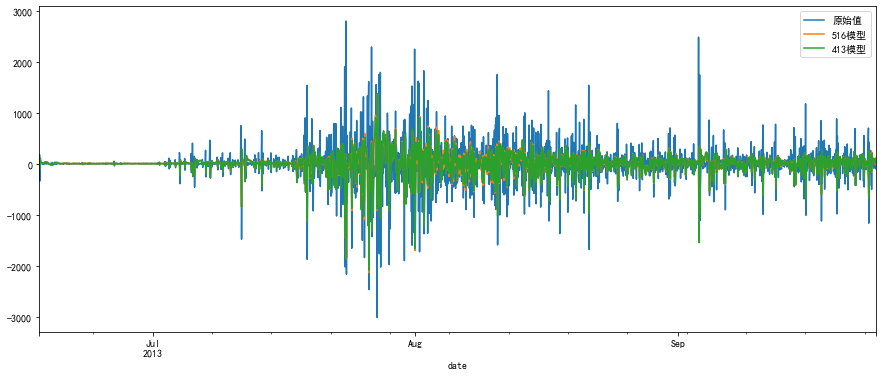

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
modeldf = pd.DataFrame({'原始值': diff})
modeldf['516模型'] = arima516.fittedvalues
modeldf['413模型'] = arima413.fittedvalues
modeldf.plot(ax=ax)

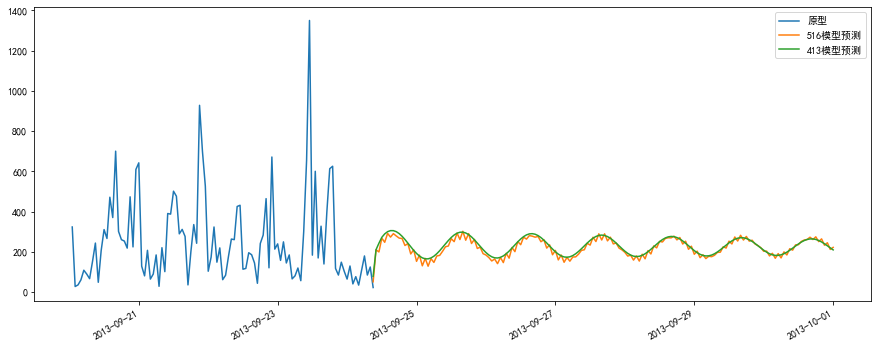

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

modeldf = pd.DataFrame({
    '516模型差分': arima516.predict('2013-09-24 09:00:00+08:00', '2013-10-1 00:00:00+08:00'),
    '413模型差分': arima413.predict('2013-09-24 09:00:00+08:00', '2013-10-1 00:00:00+08:00'),
})
modeldf['516模型预测'] = revert(modeldf['516模型差分'], count['request'][-1])
modeldf['413模型预测'] = revert(modeldf['413模型差分'], count['request'][-1])
ax.plot(count[count.index > '2013-09-20'], label='原型')
modeldf['516模型预测'].plot(ax=ax)
modeldf['413模型预测'].plot(ax=ax)
ax.legend()